In [462]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing


%config InlineBackend.figure_format = 'retina'


from sklearn import linear_model
from sklearn import metrics

# Part A

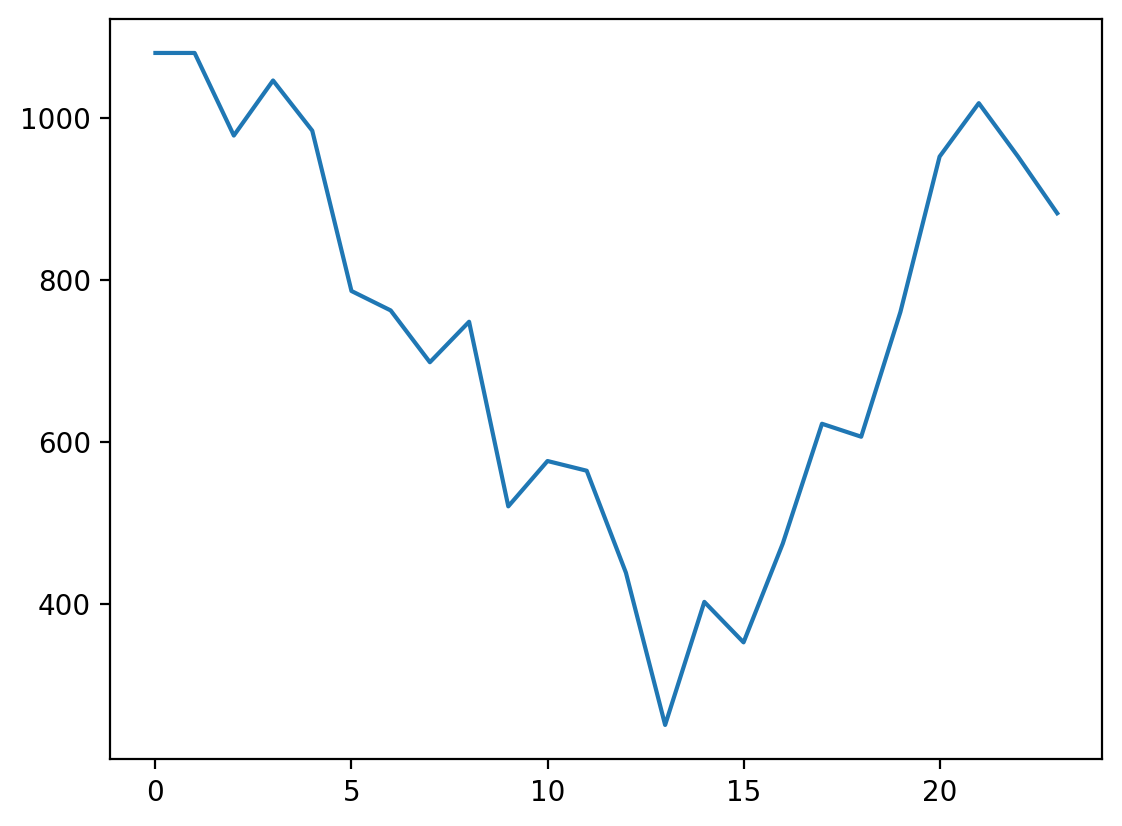

,0,1,2,3,4,5,6
0,0.674247,0.156076,0.456001,0.518172,0.152709,0.108004,-0.098016
1,0.622408,-0.059664,0.290638,0.682072,0.191430,0.087463,-0.122719
2,0.690383,0.096613,0.281747,0.593769,0.150001,0.155487,-0.188195
3,0.676285,0.047083,0.216297,0.629202,0.163049,0.183196,-0.193897
4,0.671527,0.078184,0.242049,0.593342,0.168940,0.288639,-0.142981
...,...,...,...,...,...,...,...
360,0.546498,-0.148066,0.312845,0.694564,0.210969,0.130567,-0.193832
361,0.654367,0.035276,0.288307,0.619092,0.170412,0.144631,-0.232821
362,0.480790,-0.275747,0.153370,0.756538,0.164048,0.181003,-0.193023
363,0.482390,-0.222830,0.194160,0.705220,0.229097,0.184875,-0.309758


In [463]:
data = np.array(pd.read_csv("./rsfmeasureddata2011.csv")["Building Net (kW)"])


# Split year into 365 day instances or "customers"
all_days = np.array_split(data, 365)
all_days[0][0] = all_days[0][1]


plt.plot(all_days[0])
plt.show()


# Functions to calculate attributes. These are just some examples we could change these.
def max_w(day):
    return np.max(day)


def min_w(day):
    return np.min(day)


def avg_w(day):
    return np.average(day)


def diff_w(day):
    return np.max(day) - np.min(day)


def std(day):
    return np.std(day)


def energy(day):
    return np.trapz(day)


def max_ramp(day):
    return np.max((np.gradient(day)))


def min_ramp(day):
    return np.min((np.gradient(day)))


# attribute_array = []
attribute_array = np.empty((0, 7))
for i in range(len(all_days)):
    day = all_days[i]
    attribute_array = np.append(
        attribute_array,
        [
            [
                max_w(day),
                min_w(day),
                avg_w(day),
                diff_w(day),
                std(day),
                max_ramp(day),
                min_ramp(day),
            ]
        ],
        axis=0,
    )
attribute_array = preprocessing.normalize(attribute_array, norm="l2")
pd.DataFrame(attribute_array)

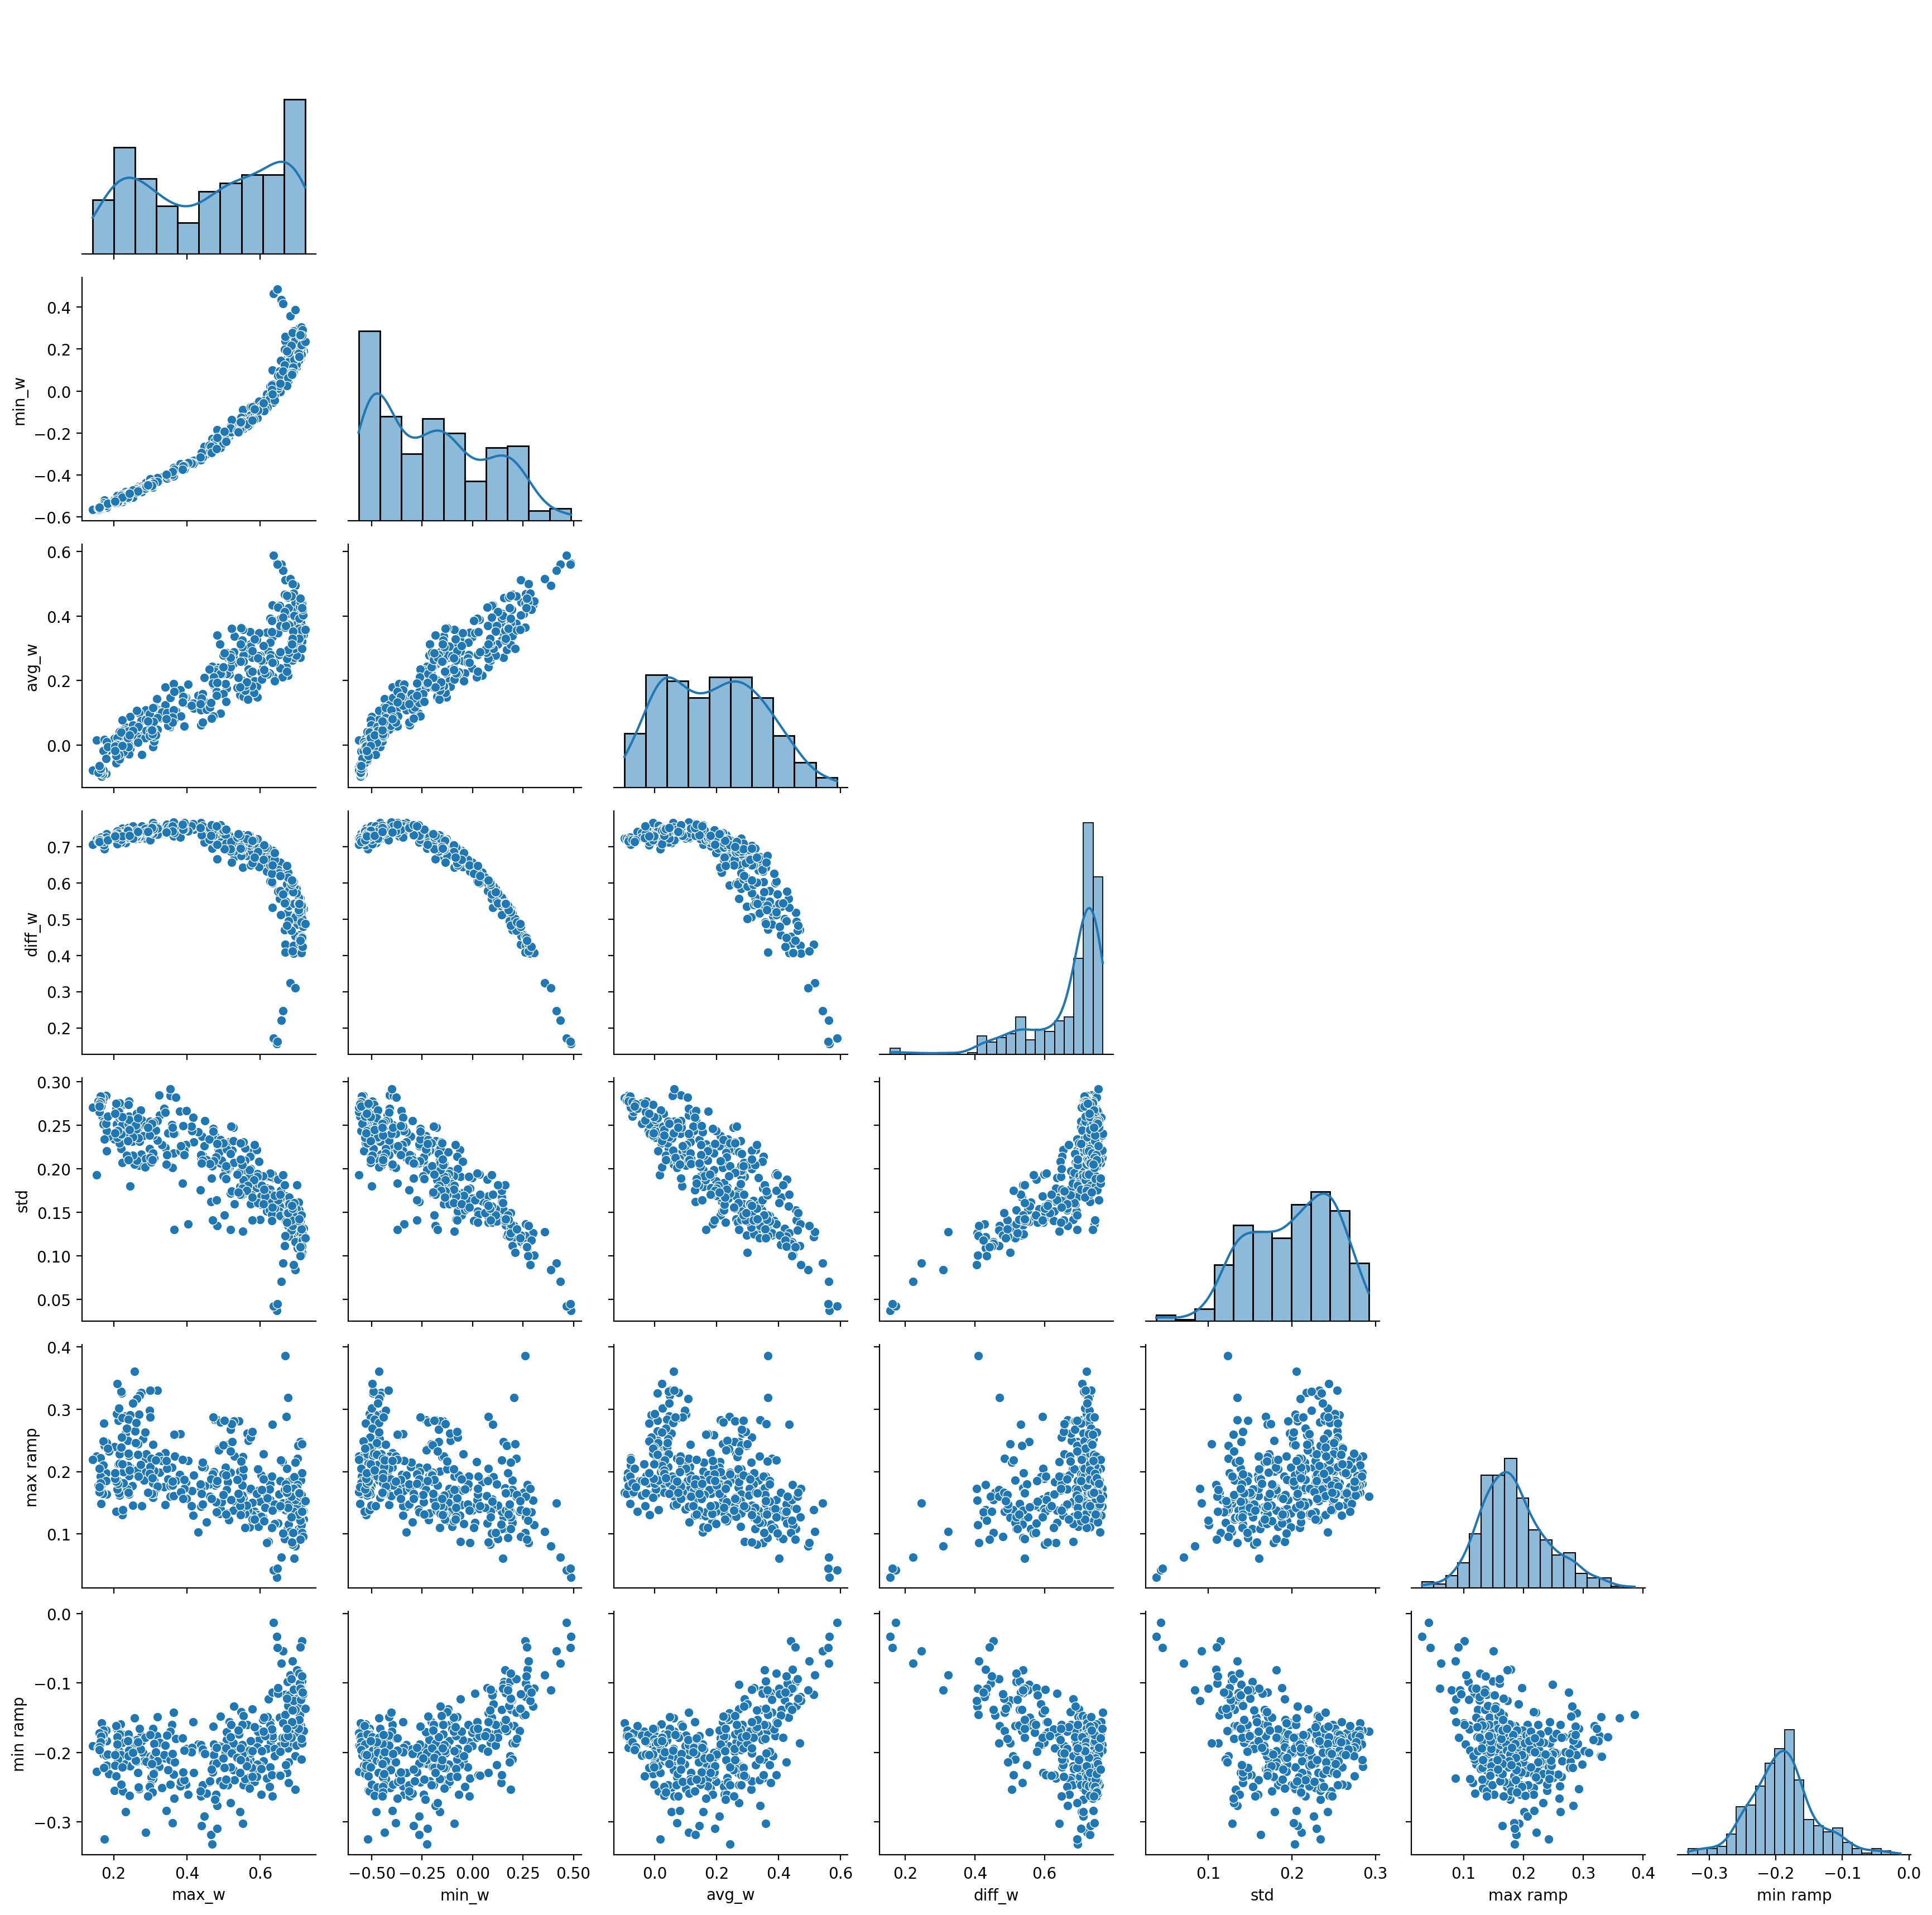

In [464]:
import seaborn as sns

df = pd.DataFrame(
    attribute_array,
    columns=[
        "max_w",
        "min_w",
        "avg_w",
        "diff_w",
        "std",
        "max ramp",
        "min ramp",
        # "energy",
    ],
)
df.to_csv("PartA.csv")
g = sns.PairGrid(df, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, kde=True)

# Part B

2 0.5627141908568007
3 0.5432634671466979


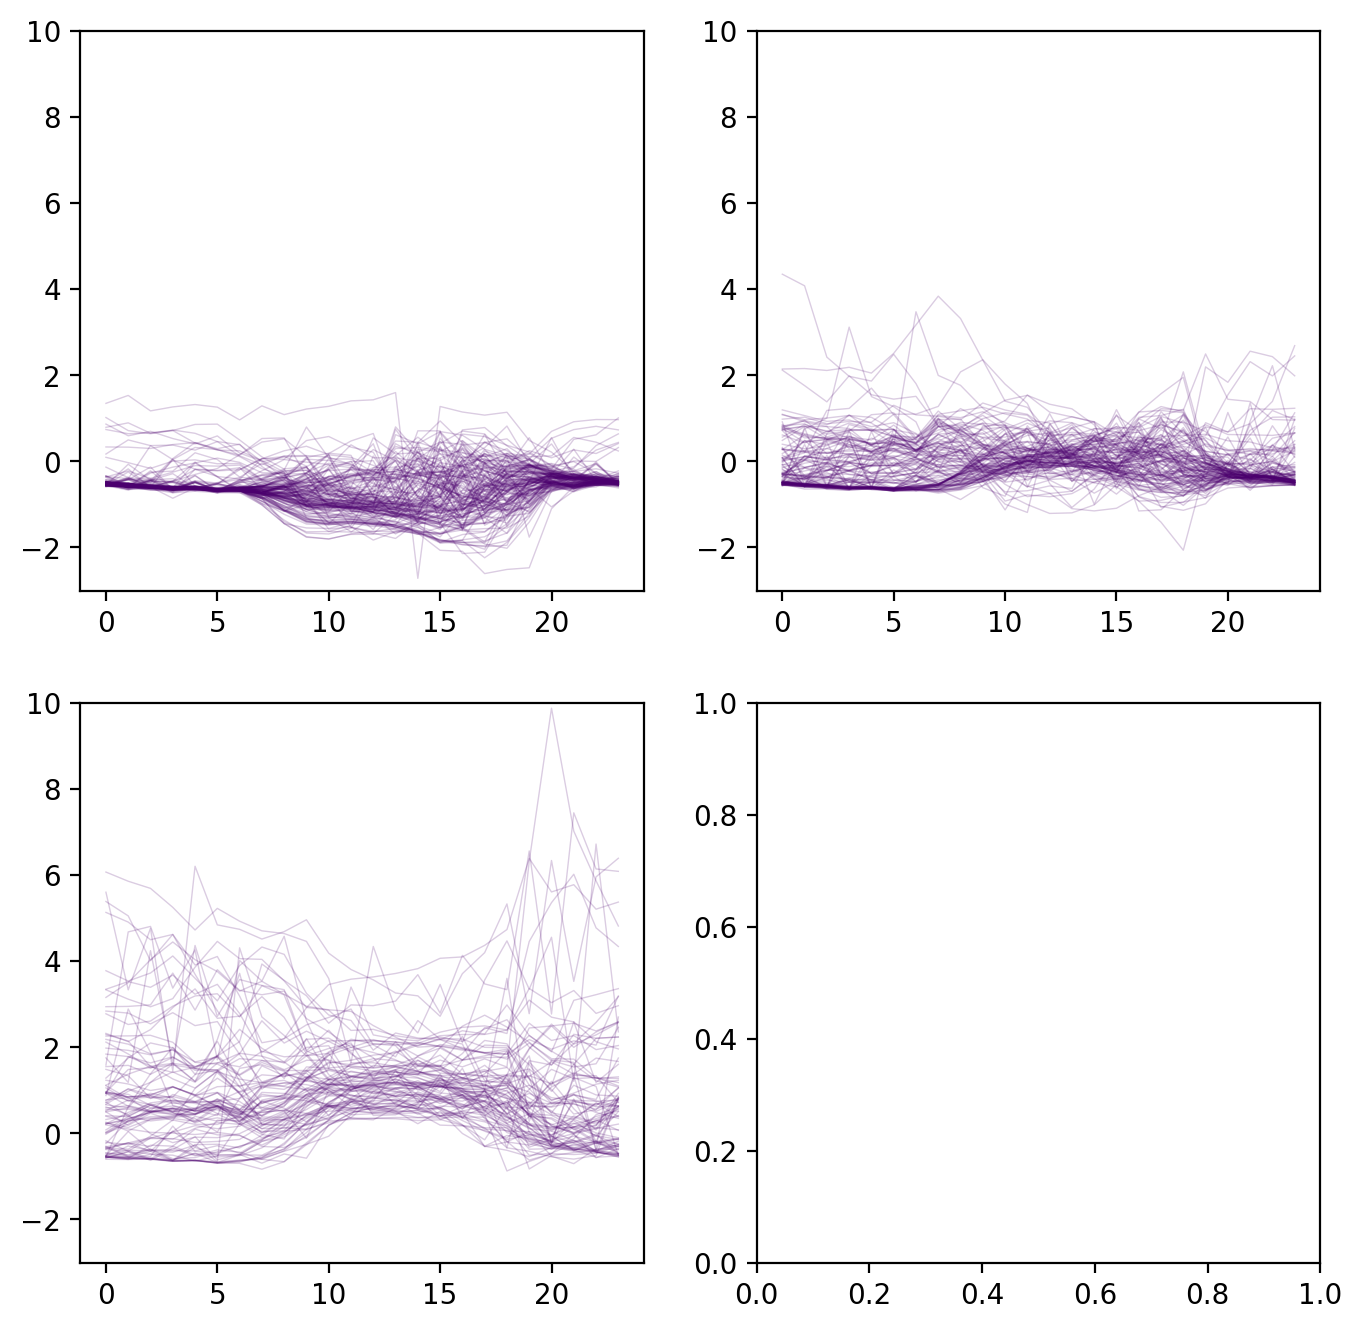

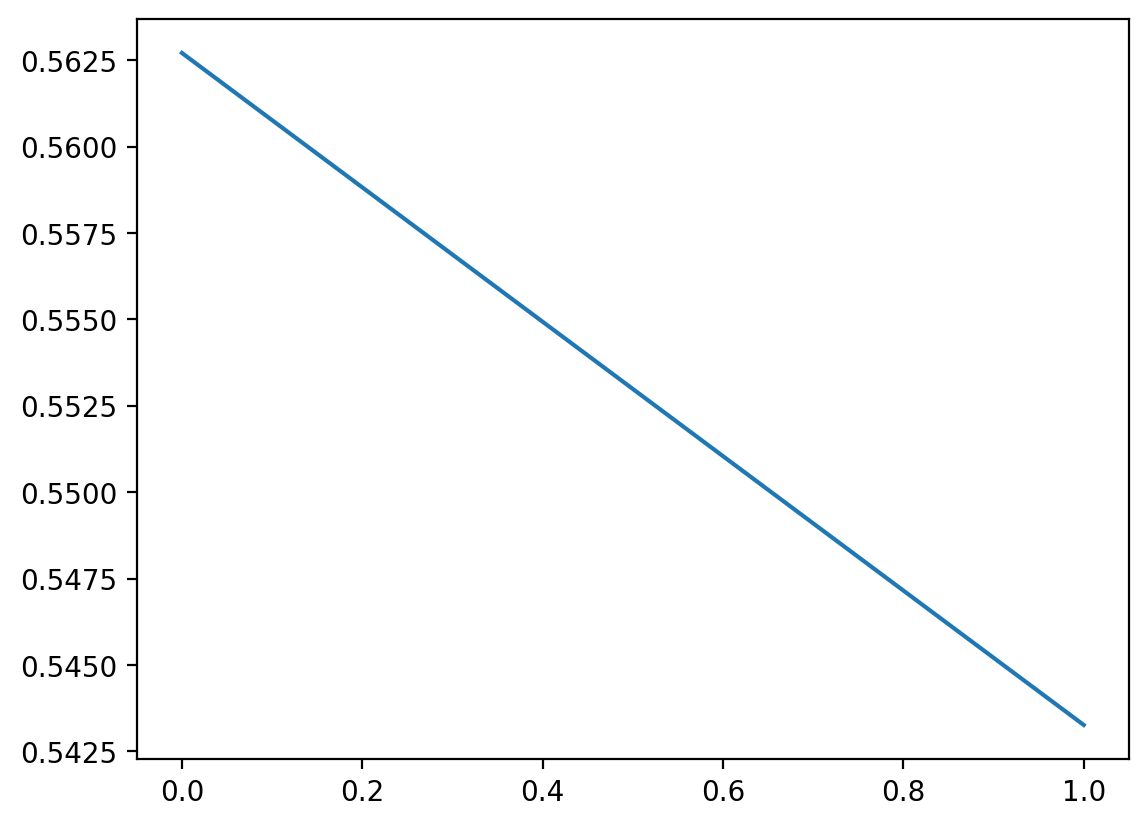

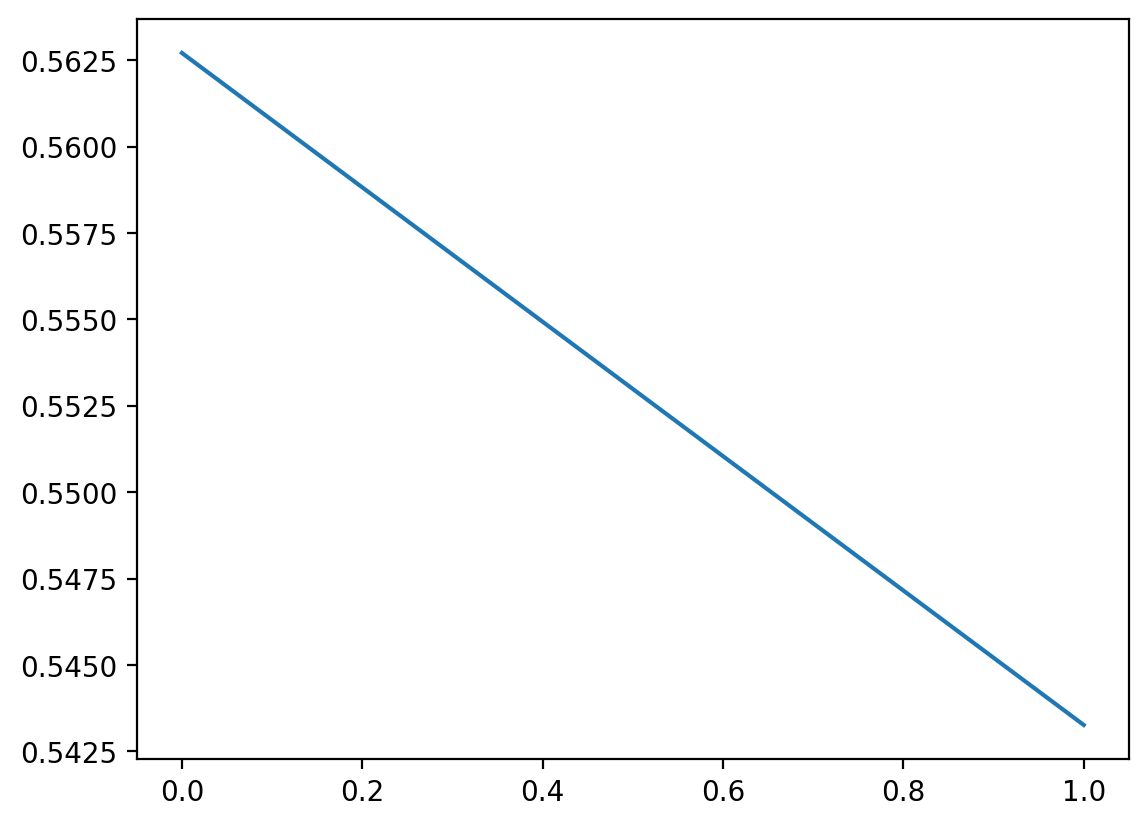

In [465]:
n_clusters_arr = np.arange(2, 4)

scores = []
for n_clusters in n_clusters_arr:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
    cluster_array = kmeans.fit_predict(attribute_array)
    # print(cluster_array)
    # I'm not sure how to best visualize this
    # How about like this

    if n_clusters == 3:
        fig, axs = plt.subplots(int(math.ceil(n_clusters / 2)), 2, figsize=(8, 8))
        axs = axs.flatten()

        np_scaled = StandardScaler().fit_transform(all_days)

        for idx, cluster_label in enumerate(cluster_array):
            np_profs = np_scaled[idx, :].T
            axs[cluster_label].plot()
            axs[cluster_label].plot(
                np_profs, alpha=0.2, linewidth=0.5, color="xkcd:royal purple"
            )

        for cluster_idx in set(cluster_array):
            axs[cluster_idx].set_ylim(-3, 10)

    score = metrics.silhouette_score(attribute_array, cluster_array, metric="euclidean")
    print(n_clusters, score)
    scores = [*scores, score]

plt.figure()
plt.plot(scores)


# from sklearn_extra.cluster import KMedoids


# scores = []
# for n_clusters in n_clusters_arr:
#     kmeans = KMedoids(
#         n_clusters=n_clusters,
#         random_state=0,
#         metric=metrics.pairwise_distances(attribute_array, metric="mahalanobis"),
#         # metric_params={"VI": np.cov(attribute_array, rowvar=False)},
#     )
#     cluster_array = kmeans.fit_predict(attribute_array)
#     # print(cluster_array)
#     # I'm not sure how to best visualize this
#     # How about like this

#     if n_clusters == 4:
#         fig, axs = plt.subplots(int(math.ceil(n_clusters / 2)), 2, figsize=(8, 8))
#         axs = axs.flatten()

#         np_scaled = StandardScaler().fit_transform(all_days)

#         for idx, cluster_label in enumerate(cluster_array):
#             np_profs = np_scaled[idx, :].T
#             axs[cluster_label].plot()
#             axs[cluster_label].plot(
#                 np_profs, alpha=0.2, linewidth=0.5, color="xkcd:royal purple"
#             )

#         for cluster_idx in set(cluster_array):
#             axs[cluster_idx].set_ylim(-3, 10)

#     score = metrics.silhouette_score(attribute_array, cluster_array, metric="euclidean")
#     print(n_clusters, score)
#     scores = [*scores, score]

plt.figure()
plt.plot(scores)

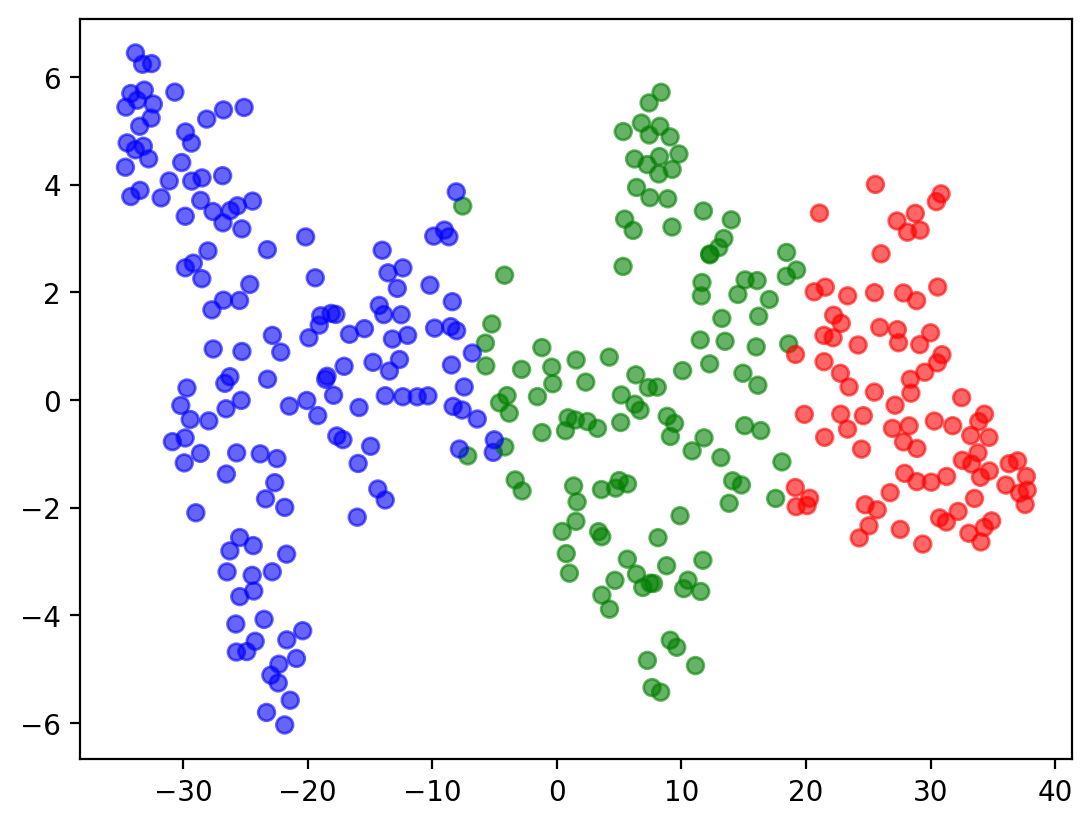

In [466]:
from sklearn.manifold import TSNE
import matplotlib.colors

tsne = TSNE()
results_tsne = tsne.fit_transform(attribute_array)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    cluster_array, ["blue", "green", "red"]
)

plt.scatter(
    results_tsne[:, 0],
    results_tsne[:, 1],
    c=cluster_array,
    cmap=cmap,
    alpha=0.6,
)

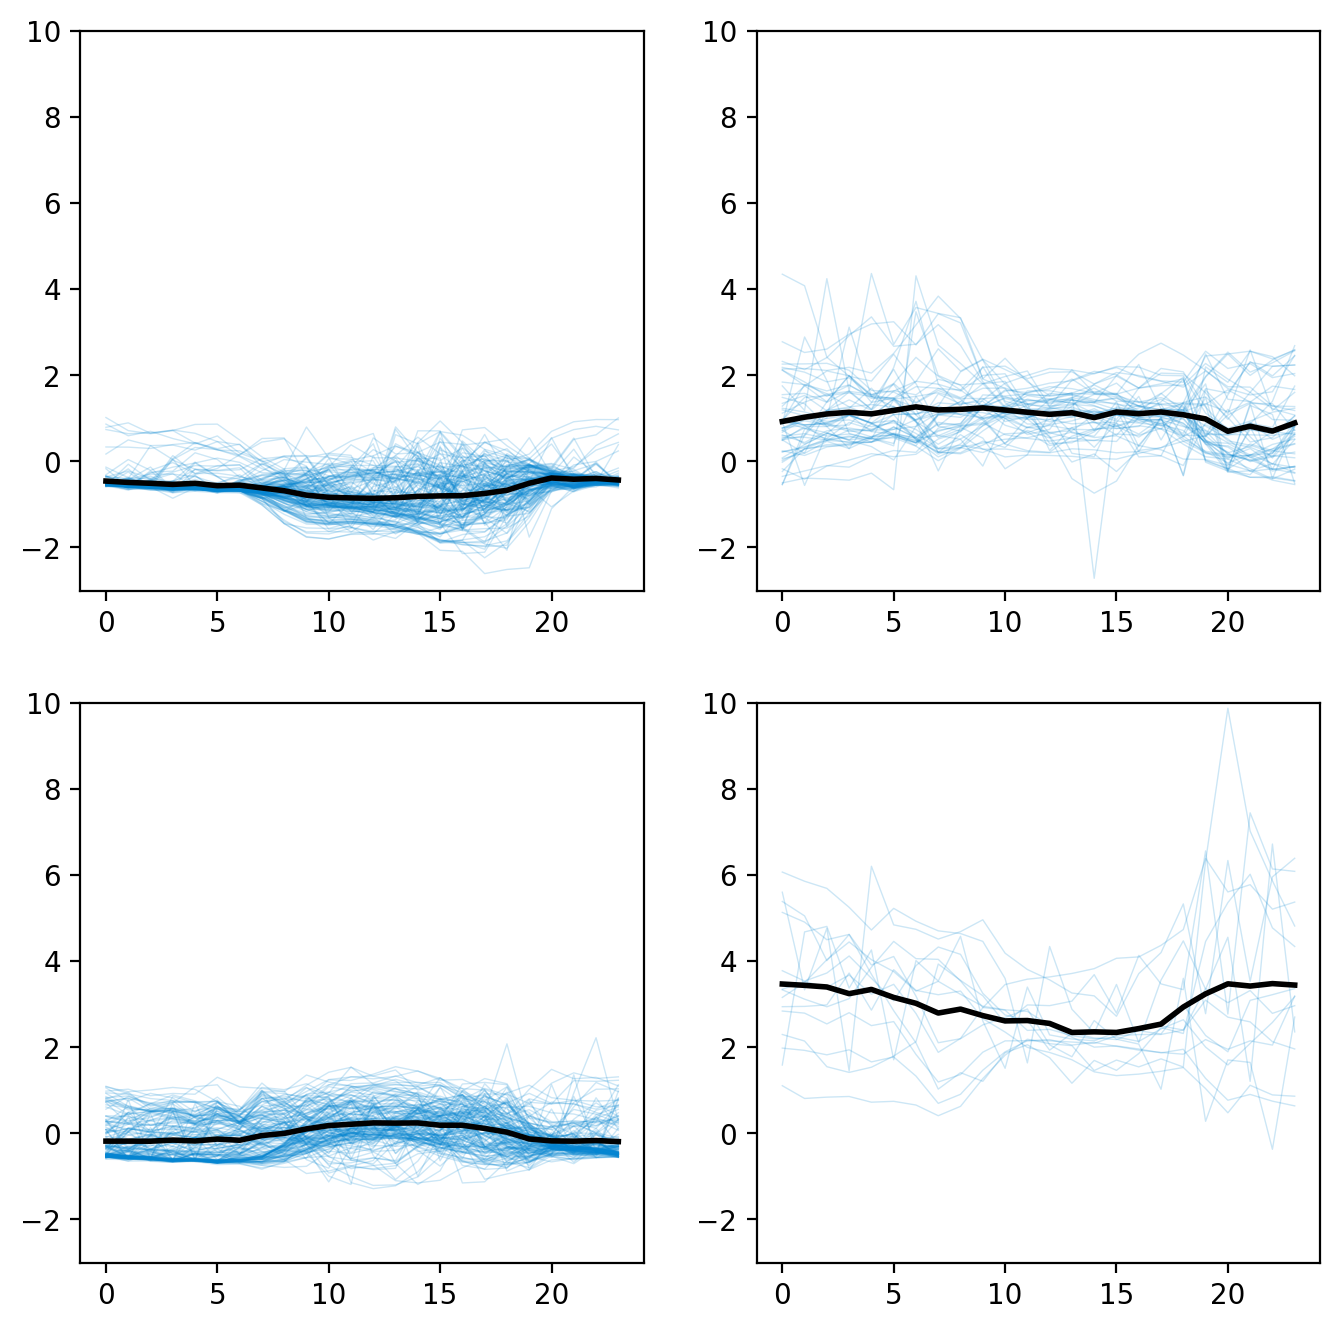

In [467]:
# This isn't actually what we've been asked to do but it might give us a better idea of number of clusters. Uses the whole time series of each day as opposed to the attributes


np_scaled = StandardScaler().fit_transform(all_days)


n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=100, n_init="auto")

df_preds = kmeans.fit_predict(np_scaled)

fig, ax = plt.subplots(int(math.ceil(n_clusters / 2)), 2, figsize=(8, 8))
ax = ax.flatten()

avgs = []
cluster_pop = []
for idx in np.unique(df_preds):
    indices = np.where(df_preds == idx)[0]

    cluster_pop.append(len(indices))
    np_profs = np_scaled[indices, :].T

    ax[idx].plot(np_profs, alpha=0.2, linewidth=0.5, color="xkcd:cerulean")

    ax[idx].plot(np.mean(np_profs, axis=1), color="black", linewidth=2)
    ax[idx].set_ylim(-3, 10)
    avgs.append(np.mean(np_profs, axis=1))

# Part C

Logistic Regression Classifier
	prediction [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 1 1 2 2 2 2 1 1 1 1 1 0]
	actual     [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 2 2 2 2 1 1 2 1 1 0]
	score on train 0.9700598802395209
	score on test 0.9354838709677419
	0.9354838709677419

K Neighbors Classifer
	prediction [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 2 2 2 2 1 1 1 1 1 0]
	actual     [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 2 2 2 2 1 1 2 1 1 0]
	score on train 0.9910179640718563
	score on test 0.967741935483871

Linear Discriminant Analysis
	prediction [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 2 2 2 2 1 1 1 1 1 0]
	actual     [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 2 2 2 2 1 1 2 1 1 0]
	score on train 0.9640718562874252
	score on test 0.967741935483871


Text(0.5, 1.0, 'LDA')

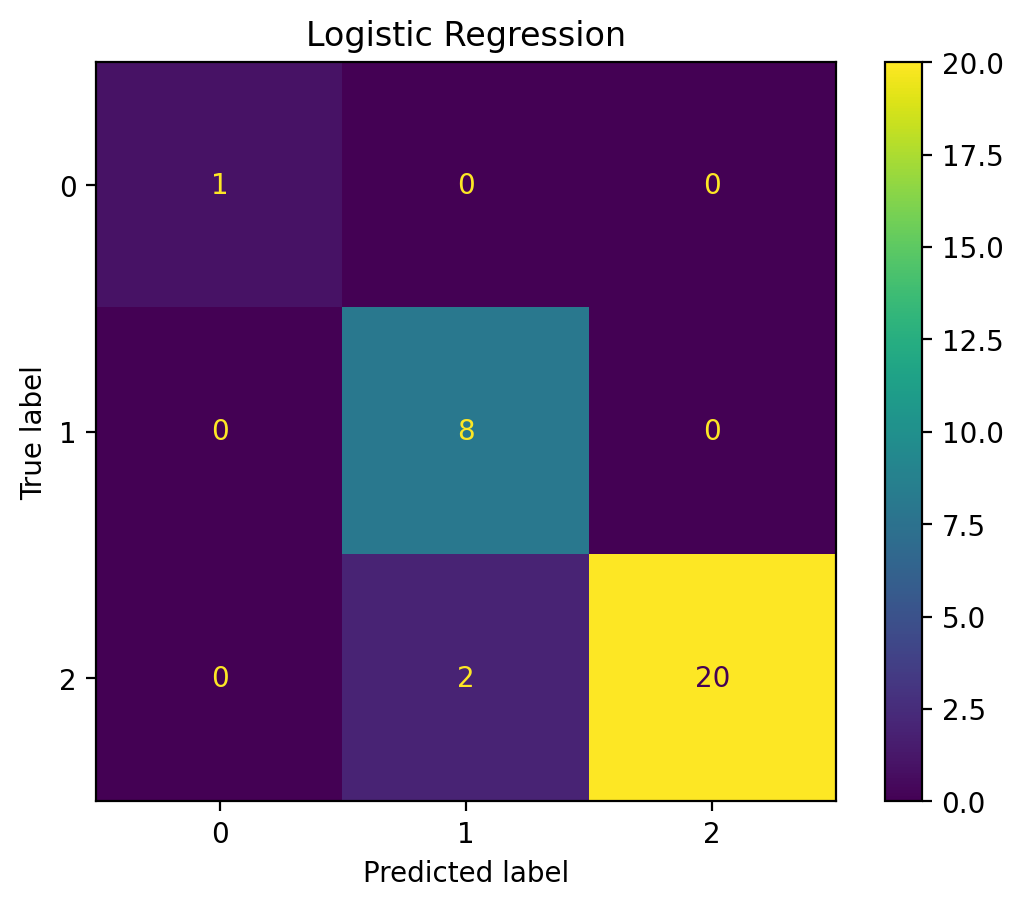

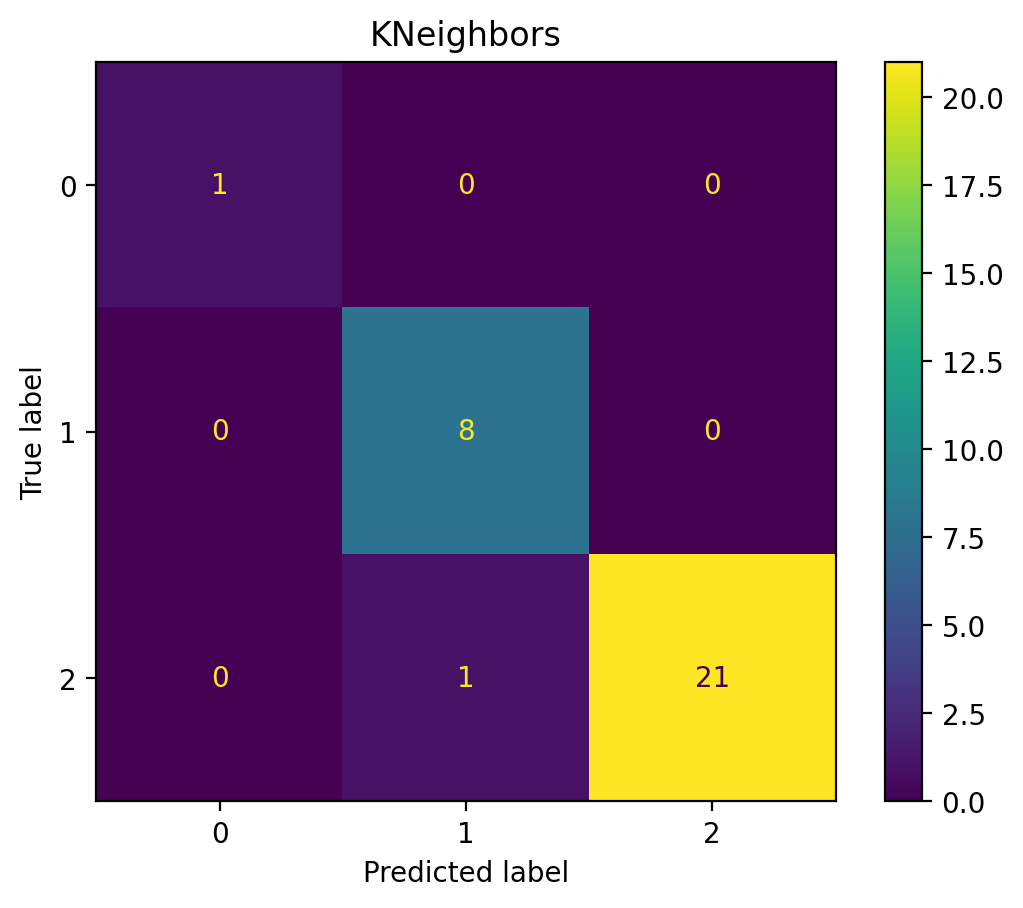

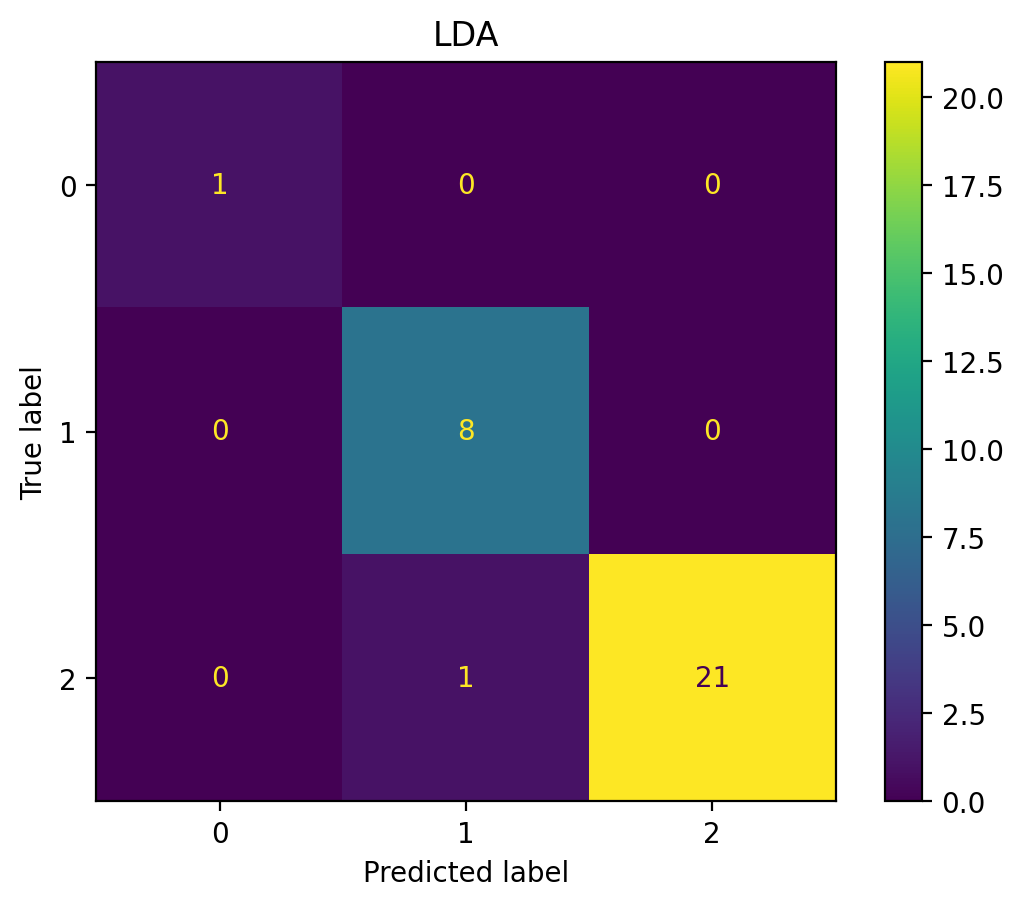

In [468]:
x_train = attribute_array[:334][:]
x_test = attribute_array[-31:][:]
y_train = cluster_array[:334]
y_test = cluster_array[-31:]


# Logistic regression classifier
print("Logistic Regression Classifier")
lr = linear_model.LogisticRegression()
lr.fit(x_train, y_train)


prediction = lr.predict(x_test)
print("\tprediction", prediction)
print("\tactual    ", y_test)
print("\tscore on train", lr.score(x_train, y_train))
print("\tscore on test", lr.score(x_test, y_test))
print(f"\t{metrics.accuracy_score(y_test, prediction)}")  # same resullt as above line

confusion = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion)
disp.plot()
ax = plt.gca()
ax.set_title("Logistic Regression")


# KNeighbors Classifier
print("\nK Neighbors Classifer")
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train, y_train)
prediction = neigh.predict(x_test)
print("\tprediction", prediction)
print("\tactual    ", y_test)
print("\tscore on train", neigh.score(x_train, y_train))
print("\tscore on test", neigh.score(x_test, y_test))

confusion = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion)
disp.plot()
ax = plt.gca()
ax.set_title("KNeighbors")


print("\nLinear Discriminant Analysis")

lda_classifier = LinearDiscriminantAnalysis().fit(x_train, y_train)
lda_classifier.fit(x_train, y_train)
prediction = lda_classifier.predict(x_test)
print("\tprediction", prediction)
print("\tactual    ", y_test)
print("\tscore on train", lda_classifier.score(x_train, y_train))
print("\tscore on test", lda_classifier.score(x_test, y_test))

confusion = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion)
disp.plot()
ax = plt.gca()
ax.set_title("LDA")